In [1]:
%matplotlib inline

In [2]:
%load_ext memory_profiler
%load_ext autotime

# Cosmic Integration

The duration from the birth of the binary until the merger as a double compact object (DCO) can range from a few million years (lifetime of the stars) to more than 100 giga years depending on the evolution of the system.

Hence, 
1. DCOs merge at different redshifts
2. Multiple DCOs merging at a specific redshift could have formed at different times.
    
We thus need to know the star formation that went into forming a single system. However, the star formation rate is non-constant over the lifetime of the universe. Furthermore, star formation is heavily dependent on the metallicity of the star forming gas, which also changes over the lifetime of the universe. Combined, we call this the metallicity-specific star formation rate (MSSFR).

**The cosmic-integration code predicts the merger rate of DCOs along a grid of redshifts and chirp-masses, assuming a model for the MSSFR.**
This tutorial covers how to use the COMPAS Cosmic Integration python tools (see [Neijssel et al. 2020](https://arxiv.org/abs/1906.08136) for derivations). 



## Load COMPAS BBHs

To run the Cosmic-integrator, we need a COMPAS data set with non-constant (preferably, randomly-sampled) metallicity and some number of double compact objects. 

In this tutorial we make a mock-COMPAS dataset. Some realistic example data can be downloaded from our [Zenodo database](https://zenodo.org/communities/compas/?page=1&size=20).


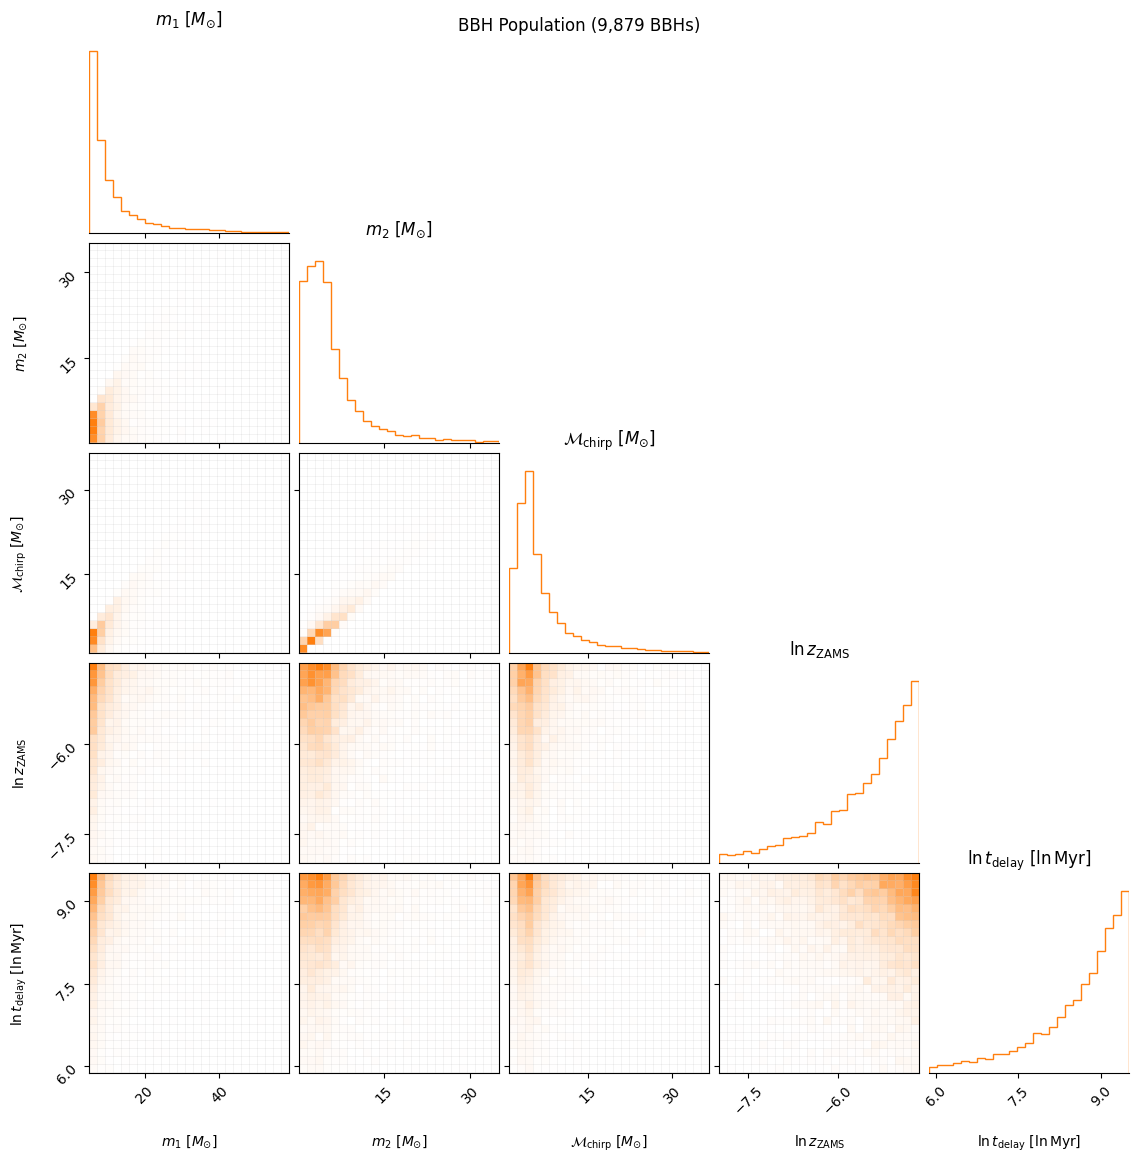

In [3]:
import numpy as np
from compas_python_utils.cosmic_integration.binned_cosmic_integrator.bbh_population import generate_mock_bbh_population_file
from compas_python_utils.cosmic_integration.binned_cosmic_integrator.bbh_population import BBHPopulation

np.random.seed(42)

m1_min = 5
m1_max = 150
m2_min = 0.1

compas_fname = generate_mock_bbh_population_file(
    "mock_compas_data.h5", n_systems=int(1e4), frac_bbh=1,
    m1_min=m1_min, m1_max=m1_max, m2_min=m2_min
)
bbh_population = BBHPopulation.from_compas_h5(compas_fname, m1_min=m1_min, m1_max=m1_max, m2_min=m2_min)
fig = bbh_population.plot()

In order to calculate the formation rate of BBHs at a given redshift, we need to know:

- The grid of metallicities we assume for the integral
- The amount of solar mass evolved per metallicity per system $dZ/dM_{\odot}$
- Each DCOs'
    - metallicity at formation
    - delay time $t_{\rm delay}$ (time from formation till merger)
    - merger time $t_c$ for each DCO
    - component masses $m_1, m_2$ at $t_c$ (for selection effects)

Given a time at which the BBH merges we can then calculate the time at which the BBH formed to recover the MSSFR ($dM_{\odot}/dt)$

## Select a MSSFR model


The universe evolved over time and as such the star formation rate and the metallicity of the starforming gas change. The metallicity-specific star formation rate (MSSFR) determines the amount of star formation that went into forming a system born at redshift z, in a metallicity bin dZ.

A schematic picture of how the MSSFR is constructed is given in Figure 10 of the COMPAS methods paper and added below (note that SFRD stands for Star Formation Rate Distribution, which is the same as the MSSFR).

![https://raw.githubusercontent.com/TeamCOMPAS/COMPAS/dev/misc/examples/Tutorials/SFRD_cartoon.png](https://raw.githubusercontent.com/TeamCOMPAS/COMPAS/dev/misc/examples/Tutorials/SFRD_cartoon.png)

In the Cosmic-integrator code, this can be done by using the `CosmologicalModel` class (the parameters are taken from [Neijssel et al. 2020](https://arxiv.org/abs/1906.08136)):



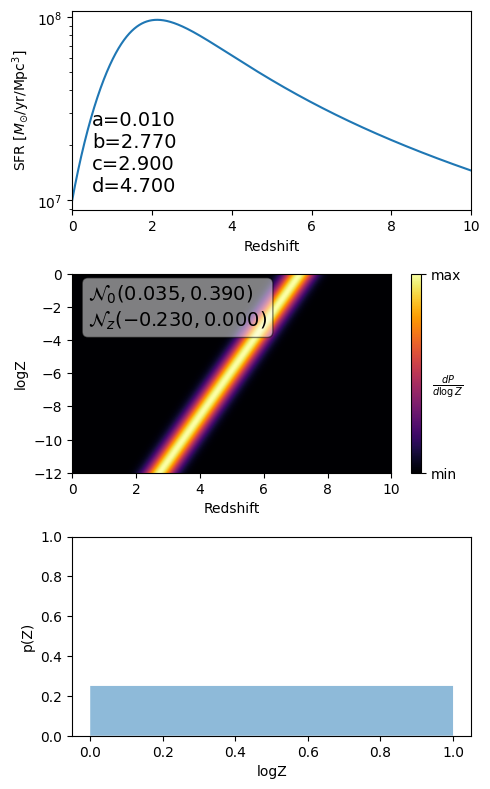

In [4]:
from compas_python_utils.cosmic_integration.binned_cosmic_integrator.cosmological_model import CosmologicalModel

cosmological_model = CosmologicalModel(
    aSF=0.01, bSF=2.77, cSF=2.90, dSF=4.70,
    mu_0=0.035, sigma_0=0.39, mu_z=-.23, sigma_z=0, alpha=0,
    min_observed_log_metallicity=-4,
    max_observed_log_metallicity=0,
)

fig = cosmological_model.plot()

## Accounting for selection effects and observation sensitivity

Before we can calculate the formation rate of BBHs at a given redshift, we need to account for selection effects and observation sensitivity.
We determine if we can confidently select a system by choosing a signal-to-noise ratio (SNR), for which we often use 8.
The SNR of a binary depends on:
- its component masses,
- its distance and the sky-orientation (compared to the gravitational wave detector)
- the sensitivity of the detector

After accounting for the above, we can compute a grid of SNRs for a grid of component masses (note: we can alter the distance and sky-orientation later on).

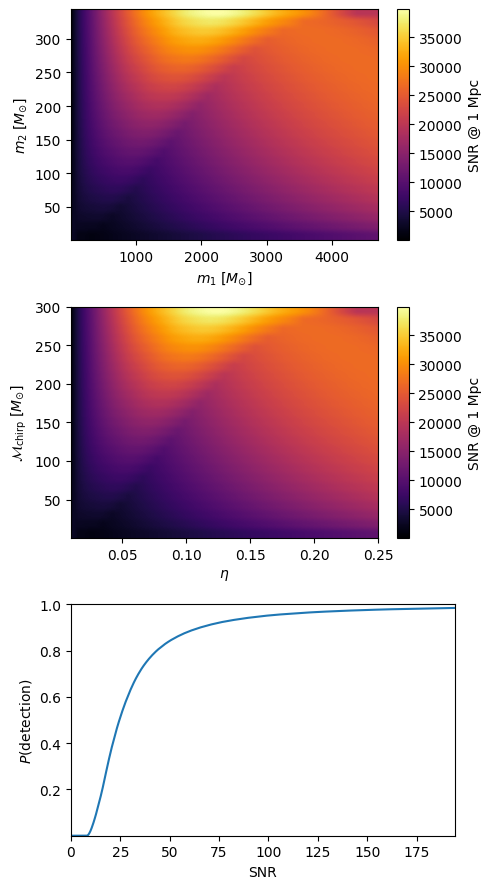

In [5]:
from compas_python_utils.cosmic_integration.binned_cosmic_integrator.snr_grid import SNRGrid

snr_grid = SNRGrid()
fig = snr_grid.plot()

## Run the cosmic-integrator

Finally, we can run the cosmic-integrator.
This iterates over all the binaries in the COMPAS data set and calculates the formation rate of each binary given an MSSFR, producing a formation rate distribution (FRD) as a function of redshift for each binary. Accounting for the selection effects we can then compute the detection rate for each binary.

As each binary has a chirp-mass, we can bin all the detection rates as a into chirp-mass and redshift bins, which is called the detection matrix.

In [6]:
from compas_python_utils.cosmic_integration.binned_cosmic_integrator.detection_matrix import DetectionMatrix, compute_binned_detection_rates

rate_matrix = compute_binned_detection_rates(
    bbh_population, cosmological_model, snr_grid,
    chirp_mass_bins=np.linspace(3,40, 20),
    redshift_bins=np.linspace(0, 1, 20),
)

Computing detection rates:   0%|          | 0/9879 [00:00<?, ?it/s]

We have a helper class to do this in one go:

Computing detection rates:   0%|          | 0/9879 [00:00<?, ?it/s]

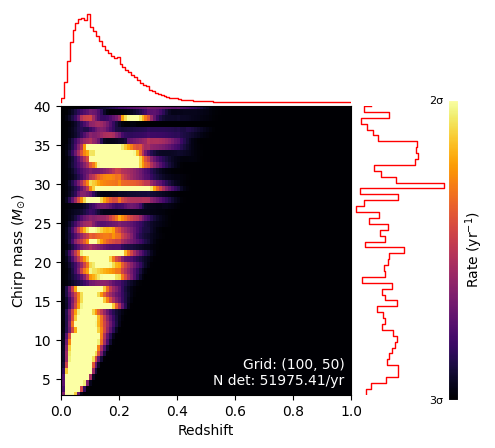

In [7]:
detection_matrix = DetectionMatrix.from_compas_output(
        compas_fname,  save_plots=False,
        chirp_mass_bins=50, redshift_bins=100,
        cosmological_parameters=dict(aSF=0.01, dSF=4.70, mu_z=-.23, sigma_z=0),
    )
fig = detection_matrix.plot()

The integration can be executed without binning the detection rates (this is not recommended for large data sets for memory reasons).


## Bootstrapping

You may want to generate $N$ detection-rate matrices using bootstrap samples from the original BBH population. This can be done with: 

Bootstrapping rate matrices:   0%|          | 0/5 [00:00<?, ?it/s]

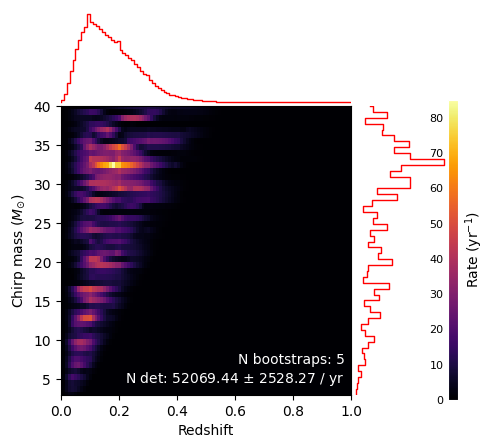

In [8]:
detection_matrix.compute_bootstrapped_rate_matrices(
    bbh_population, cosmological_model=cosmological_model, snr_grid=snr_grid,
    n_bootstraps=5
)
fig = detection_matrix.plot_bootstrapped_uncertainty()


## GPU usage
If you have a CUDA-enabled GPU, the cosmic-integrator will automatically use it to speed up the calculation. To check if your GPU is used, you can run the following

In [10]:
from compas_python_utils.cosmic_integration.binned_cosmic_integrator.gpu_utils import gpu_available

print(f"GPU available: {gpu_available}")

GPU available: False


## Acknowledgements
If you use the cosmic-integration code, please cite:

```bib

@ARTICLE{2018MNRAS.477.4685B,
       author = {{Barrett}, Jim W. and {Gaebel}, Sebastian M. and {Neijssel}, Coenraad J. and {Vigna-G{\'o}mez}, Alejandro and {Stevenson}, Simon and {Berry}, Christopher P.~L. and {Farr}, Will M. and {Mandel}, Ilya},
        title = "{Accuracy of inference on the physics of binary evolution from gravitational-wave observations}",
      journal = {\mnras},
     keywords = {black hole physics, gravitational waves, stars: black holes, stars: evolution, Astrophysics - High Energy Astrophysical Phenomena, Astrophysics - Solar and Stellar Astrophysics, Physics - Data Analysis, Statistics and Probability},
         year = 2018,
        month = jul,
       volume = {477},
       number = {4},
        pages = {4685-4695},
          doi = {10.1093/mnras/sty908},
archivePrefix = {arXiv},
       eprint = {1711.06287},
 primaryClass = {astro-ph.HE},
       adsurl = {https://ui.adsabs.harvard.edu/abs/2018MNRAS.477.4685B},
      adsnote = {Provided by the SAO/NASA Astrophysics Data System}
}

@ARTICLE{2019MNRAS.490.3740N,
       author = {{Neijssel}, Coenraad J. and {Vigna-G{\'o}mez}, Alejandro and {Stevenson}, Simon and {Barrett}, Jim W. and {Gaebel}, Sebastian M. and {Broekgaarden}, Floor S. and {de Mink}, Selma E. and {Sz{\'e}csi}, Dorottya and {Vinciguerra}, Serena and {Mandel}, Ilya},
        title = "{The effect of the metallicity-specific star formation history on double compact object mergers}",
      journal = {\mnras},
     keywords = {gravitational waves, (stars:) binaries: general, stars: massive, galaxies: star formation, Astrophysics - Solar and Stellar Astrophysics, Astrophysics - Astrophysics of Galaxies},
         year = 2019,
        month = dec,
       volume = {490},
       number = {3},
        pages = {3740-3759},
          doi = {10.1093/mnras/stz2840},
archivePrefix = {arXiv},
       eprint = {1906.08136},
 primaryClass = {astro-ph.SR},
       adsurl = {https://ui.adsabs.harvard.edu/abs/2019MNRAS.490.3740N},
      adsnote = {Provided by the SAO/NASA Astrophysics Data System}
}
```

#### Older version of Cosmic-integrator

The cosmic-integrator code has undergone a major overhaul in 2023. If you would like to use the previous version, you can find it [here](https://github.com/TeamCOMPAS/COMPAS/tree/8af87e8e84568da11133deae034e23aee92c68e9). Please let the COMPAS team know that you are using this version, so we can know that there is still interest in this version.